In [1]:
#MATH 691Y - Project 
#sim_annealing.py
#Simulated annealing demo with TSP
#https://visualstudiomagazine.com/articles/2021/12/01/~/media/ECG/visualstudiomagazine/Images/2021/12/fig_1_tsp_annealing_demo_run.ashx 

In [2]:
import numpy as np 
import random 
import networkx as nx 
import matplotlib.pyplot as plt 


rnd = np.random.RandomState(4) # random object for adjacent routes
num_loggers = 5
num_mills = 5

xcoord = [0,6.449176277857582, 2.34782915, 7.638949,3.682908, 8.25739, 8.210159364492801, 1.9591033904708433, 7.683727323272914, 4.437519279118743, 7.475798973242043,0]
ycoord = [0,5.169304535502429, 5.48392761, 5.428358, 3.947827, 7.273826, 7.400174360896942, 7.562614454164295, 1.0266328053710538, 2.0134066917963, 6.752904060405664,0]

# dist_mat = np.array([[58,40,42,19,41], [15,35,62,83,33], [35,54,74,102,52],[96,74,90,57,76]]) # distance from logger i to mill j
demand_mat = np.array([[1,0,3,0],[4,0,0,0],[0,9,0,0],[0,4,9,0]])

init_temp = 100
final_temp = 1
cooling = 0.9

In [3]:
"""
Generate list of loggers. 
Odd number representation starting with 1
Parameters: number of loggers 
Returns: list of loggers
"""
def generate_loggers(num_loggers):
    loggers = list()
    for i in range(1,num_loggers*2,2):
        loggers.append(i)
    return loggers

"""
Generate list of mills. 
Even number representation starting with 2
Parameters: number of mills 
Returns: list of mills 
"""
def generate_mills(num_mills):
    mills = list()
    for i in range(2,num_mills*2+1,2):
        mills.append(i)
    return mills 

In [4]:
"""
Generate random path starting from logger --> mill  
Parameters: list of loggers, list of mills, number of location 
pairs to visit 
Returns: route
"""
def generate_rand_path(loggers,mills,nlocations):
    path = list()
   
    new_loggers = loggers.copy()
    new_mills = mills.copy()
    
    l = len(loggers)
    m = len(mills)
    
    if l < m:
        diff = m - l
        for i in range(diff):
            new_loggers.append(random.randrange(1,loggers[-1]+2,2))
    elif m < l:
        diff = l - m
        for i in range(diff):
            new_mills.append(random.randrange(2,mills[-1]+2,2))
        
    np.random.shuffle(new_loggers)
    np.random.shuffle(new_mills)
    
    new_loggers2 = new_loggers[:nlocations]
    new_mills2 = new_mills[:nlocations]

    path.append(0)
    for i in range(len(new_loggers2)):
        path.append(new_loggers2[i])
        path.append(new_mills2[i])
            
    path.append(0)
    return path 

def adjacent(route,rnd):
    n = len(route)
    
    parity = rnd.randint(0,2)
    first_loc = 0
    second_loc = 0

    while ( first_loc >= second_loc):
    
        if (parity == 0):
            first_loc = rnd.randint(1,n/2) * 2
            second_loc = rnd.randint(1,n/2) * 2
        else:
            first_loc = rnd.randint(1,n/2) * 2 - 1
            second_loc = rnd.randint(1,n/2) * 2 - 1

#     print("\nFirst loc",first_loc,"\nSecond loc",second_loc)
        
    new_path = list()
    
    temp = route[first_loc]
    
    for i in range(n):
        if i == first_loc:
            new_path.append(route[second_loc])
        elif i == second_loc:
            new_path.append(temp)
        else:        
            new_path.append(route[i])
        
    return new_path

def generate_path(loggers,mills,d):
    path = list()
    
    new_loggers = list()
    new_mills = list()
    
    l = len(loggers)
    m = len(mills)
    
    if l < m:
        diff = m - l
        for i in range(diff):
            new_loggers.append(random.randrange(1,loggers[-1]+2,2))
    elif m < l:
        diff = l - m
        for i in range(diff):
            new_mills.append(random.randrange(2,mills[-1]+2,2))
            
    for i in range(l):
        if d.get(loggers[i]) == 0:
            new_loggers.append(loggers[i])
        if d.get(mills[i]) == 0:
            new_mills.append(mills[i])
    
    np.random.shuffle(new_loggers)
    np.random.shuffle(new_mills)

    path.append(0)
    for i in range(len(new_loggers)):
        path.append(new_loggers[i])
        path.append(new_mills[i])
            
    path.append(0)
    return path 

In [5]:
def total_dist(route,xcoord,ycoord):
    d = 0.0 
    for i in range(len(route)-1):
        d += np.sqrt ((ycoord[route[i]]-ycoord[route[i+1]])**2 + (xcoord[route[i]]-xcoord[route[i+1]])**2)
    return d


def plot_graph(route,xcoord,ycoord):
    locations = ["hub","logger1","mill2","logger3","mill4","logger5","mill6","logger7","mill8", "logger9","mill10","hub"]
    plt.scatter(xcoord,ycoord)
    for i, label in enumerate(locations):
        plt.annotate(label,(xcoord[i],ycoord[i]))
    
    xcoordnew = list()
    ycoordnew = list()
    
    for i in range(len(route)):
        xcoordnew.append(xcoord[route[i]])
        ycoordnew.append(ycoord[route[i]])

    plt.plot(xcoordnew,ycoordnew) 

In [6]:
def update_demand(route,locA,locB):
    n = 2*len(route)
    temp_demand_mat = np.ndarray.copy(demand_mat)
    for i in range(n-1):
        # path starting from logger
        if (i%2 == 0):
            temp_demand_mat[(route[i//2][locA])][(route[i//2][locB])] -= 1
        # path starting from mill
        else:
            temp_demand_mat[(route[(i+1)//2][locA])][(route[(i-1)//2][locB])] -= 1
    return temp_demand_mat

def find_overserved(route,demands):
    locA = list()
    locB = list()
    for i in range(len(demands)):
        for j in range(len(demands[0])):
            if (demands[i][j] < 0):
                locA.append(i)
                locB.append(j)
   
    return list(zip(locA,locB))

def init_locations(num_loggers,num_mills):
    loggers = generate_loggers(num_loggers)
    mills = generate_mills(num_mills)
    d = {}
    
    for i in loggers:
        d[i] = 0
    
    for i in mills:
        d[i] = 0
        
    return d
        
def availability(route):
    d = init_locations(num_loggers,num_mills)
    
    for i in range(len(route)):
        d[route[i]] = 1
        
    return d 

def solve(max_iter,init_temp,xcoord,ycoord):
    curr_temp = init_temp
    
    #Generate loggers and mills locations 
    loggers = generate_loggers(num_loggers)
    mills = generate_mills(num_mills)
    
    #Generate initial solution 
    truck1 = generate_rand_path(loggers,mills,3)
    d = availability(truck1)
    truck2 = generate_path(loggers,mills,d)
    
    plot_graph(truck2,xcoord,ycoord)
    plot_graph(truck1,xcoord,ycoord)
    plt.show()
    
    truck1_dist  = total_dist(truck1,xcoord,ycoord) 
    truck2_dist = total_dist(truck2,xcoord,ycoord)
    print("Initial Truck1 route:", truck1, "Truck 1 distance:", truck1_dist)
    print("Initial Truck2 route:",truck2, "Truck 2 distance:", truck2_dist)
    print("Total distance:", truck1_dist + truck2_dist)

    while curr_temp > final_temp:
        
#         adj_sol = adjacent(fb_sol,rnd)
        truck1_adj_sol = generate_rand_path(loggers,mills,3)
        d = availability(truck1_adj_sol)
        truck2_adj_sol = generate_path(loggers,mills,d)
        
        truck1_adj_dist = total_dist(truck1_adj_sol,xcoord,ycoord)
        truck2_adj_dist = total_dist(truck2_adj_sol,xcoord,ycoord)
#         truck1_dist = total_dist(truck1,xcoord,ycoord)
        
        if (truck1_adj_dist + truck2_adj_dist) < (truck1_dist + truck2_dist):
            truck1 = truck1_adj_sol
            truck2 = truck2_adj_sol
            plot_graph(truck1,xcoord,ycoord)
            plot_graph(truck2,xcoord,ycoord)
            plt.show()
            print("\nOld",truck1_dist,"-->New",truck1_adj_dist)
            print("\nOld",truck2_dist,"-->New",truck2_adj_dist)
            
        else:
            delta = ((truck1_adj_dist + truck2_adj_dist) - (truck1_dist + truck2_dist))
            if np.random.uniform(0,1) < ((curr_temp - delta)/curr_temp):
                truck1 = truck1_adj_sol
                truck2 = truck2_adj_sol
                plot_graph(truck1,xcoord,ycoord)
                plot_graph(truck2,xcoord,ycoord)

                plt.show()
                print("\nOld",truck1_dist,"-->New",truck1_adj_dist,"\nTemp threshold:",(curr_temp-delta)/curr_temp)
                print("\nOld",truck2_dist,"-->New",truck2_adj_dist,"\nTemp threshold:",(curr_temp-delta)/curr_temp)

        
        curr_temp = curr_temp * cooling 
        print("\nFinal route:", truck1, "\nTotal distance:",total_dist(truck1,xcoord,ycoord))
        print("\nFinal route:", truck2, "\nTotal distance:",total_dist(truck2,xcoord,ycoord))
        print("Total distance:",total_dist(truck1,xcoord,ycoord) + total_dist(truck2,xcoord,ycoord))

#         print("\nTruck2 new route:",adj_sol_truck2)
    

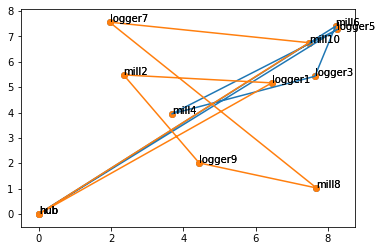

Initial Truck1 route: [0, 1, 2, 9, 8, 7, 10, 0] Truck 1 distance: 44.16107253460221
Initial Truck2 route: [0, 5, 4, 3, 6, 0] Truck 2 distance: 33.98995000363063
Total distance: 78.15102253823284


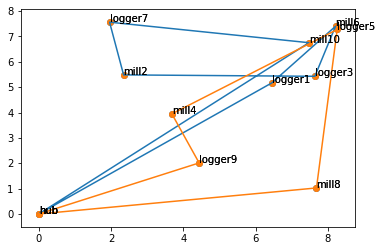


Old 44.16107253460221 -->New 36.21636706686339

Old 33.98995000363063 -->New 26.6306123164955

Final route: [0, 1, 6, 3, 2, 7, 10, 0] 
Total distance: 36.21636706686339

Final route: [0, 9, 4, 5, 8, 0] 
Total distance: 26.6306123164955
Total distance: 62.84697938335889


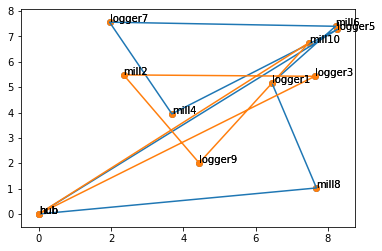


Old 44.16107253460221 -->New 41.83484832630868

Old 33.98995000363063 -->New 34.41769521738746

Final route: [0, 5, 4, 7, 6, 1, 8, 0] 
Total distance: 41.83484832630868

Final route: [0, 3, 2, 9, 10, 0] 
Total distance: 34.41769521738746
Total distance: 76.25254354369613


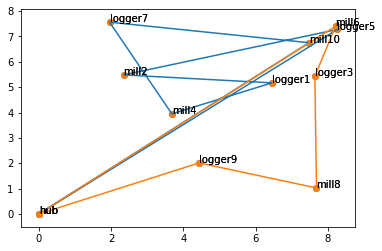


Old 44.16107253460221 -->New 43.97100997032686

Old 33.98995000363063 -->New 25.77365793455602

Final route: [0, 5, 2, 1, 4, 7, 10, 0] 
Total distance: 43.97100997032686

Final route: [0, 9, 8, 3, 6, 0] 
Total distance: 25.77365793455602
Total distance: 69.74466790488287


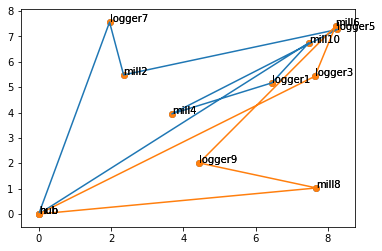


Old 44.16107253460221 -->New 36.74284705677703

Old 33.98995000363063 -->New 29.145512638065902

Final route: [0, 7, 2, 5, 4, 1, 10, 0] 
Total distance: 36.74284705677703

Final route: [0, 3, 6, 9, 8, 0] 
Total distance: 29.145512638065902
Total distance: 65.88835969484293


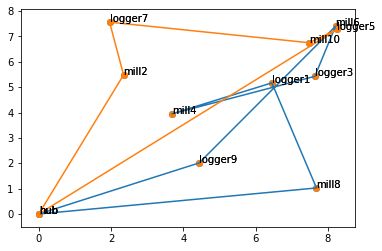


Old 44.16107253460221 -->New 32.824962713709134

Old 33.98995000363063 -->New 25.599409818865432

Final route: [0, 9, 6, 3, 4, 1, 8, 0] 
Total distance: 32.824962713709134

Final route: [0, 5, 10, 7, 2, 0] 
Total distance: 25.599409818865432
Total distance: 58.424372532574566


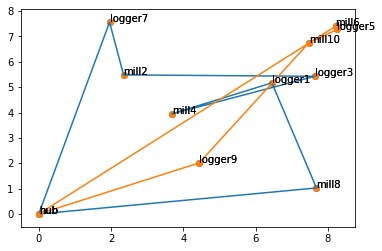


Old 44.16107253460221 -->New 34.541055282461784

Old 33.98995000363063 -->New 22.629852264470962

Final route: [0, 7, 2, 3, 4, 1, 8, 0] 
Total distance: 34.541055282461784

Final route: [0, 9, 10, 5, 6, 0] 
Total distance: 22.629852264470962
Total distance: 57.170907546932746


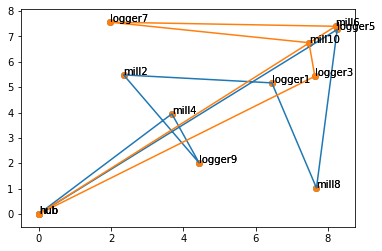


Old 44.16107253460221 -->New 37.24029465672391

Old 33.98995000363063 -->New 33.587811110561816

Final route: [0, 5, 8, 1, 2, 9, 4, 0] 
Total distance: 37.24029465672391

Final route: [0, 3, 10, 7, 6, 0] 
Total distance: 33.587811110561816
Total distance: 70.82810576728573


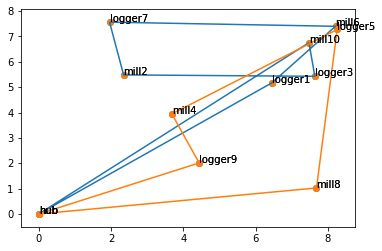


Old 44.16107253460221 -->New 36.17540203922911

Old 33.98995000363063 -->New 26.6306123164955

Final route: [0, 1, 6, 7, 2, 3, 10, 0] 
Total distance: 36.17540203922911

Final route: [0, 9, 4, 5, 8, 0] 
Total distance: 26.6306123164955
Total distance: 62.80601435572461


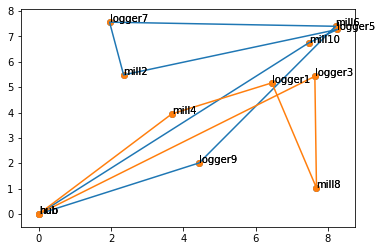


Old 44.16107253460221 -->New 37.00543571907069

Old 33.98995000363063 -->New 26.518871843028624

Final route: [0, 9, 6, 7, 2, 5, 10, 0] 
Total distance: 37.00543571907069

Final route: [0, 3, 8, 1, 4, 0] 
Total distance: 26.518871843028624
Total distance: 63.52430756209931


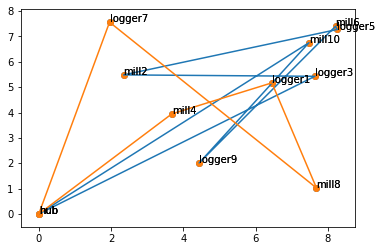


Old 44.16107253460221 -->New 43.25265096904437

Old 33.98995000363063 -->New 29.246421679942458

Final route: [0, 3, 2, 5, 6, 9, 10, 0] 
Total distance: 43.25265096904437

Final route: [0, 7, 8, 1, 4, 0] 
Total distance: 29.246421679942458
Total distance: 72.49907264898683


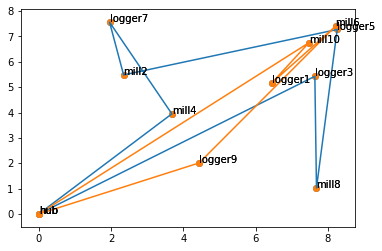


Old 44.16107253460221 -->New 37.73986045615525

Old 33.98995000363063 -->New 26.253003847959995

Final route: [0, 3, 8, 5, 2, 7, 4, 0] 
Total distance: 37.73986045615525

Final route: [0, 9, 6, 1, 10, 0] 
Total distance: 26.253003847959995
Total distance: 63.992864304115244


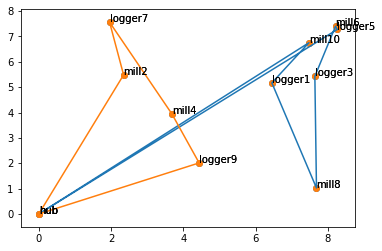


Old 44.16107253460221 -->New 33.878113914568964

Old 33.98995000363063 -->New 19.03419233756877

Final route: [0, 5, 6, 3, 8, 1, 10, 0] 
Total distance: 33.878113914568964

Final route: [0, 9, 4, 7, 2, 0] 
Total distance: 19.03419233756877
Total distance: 52.91230625213773


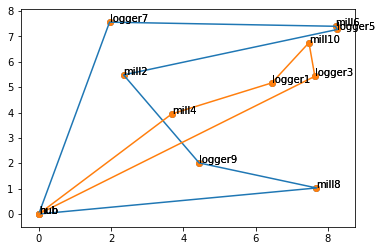


Old 44.16107253460221 -->New 35.570950697040324

Old 33.98995000363063 -->New 21.01602003805177

Final route: [0, 7, 6, 5, 2, 9, 8, 0] 
Total distance: 35.570950697040324

Final route: [0, 3, 10, 1, 4, 0] 
Total distance: 21.01602003805177
Total distance: 56.586970735092095

Final route: [0, 7, 6, 5, 2, 9, 8, 0] 
Total distance: 35.570950697040324

Final route: [0, 3, 10, 1, 4, 0] 
Total distance: 21.01602003805177
Total distance: 56.586970735092095


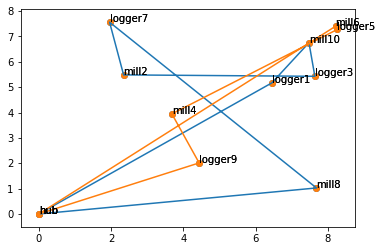


Old 44.16107253460221 -->New 35.33367870425615

Old 33.98995000363063 -->New 23.793036276427685

Final route: [0, 1, 10, 3, 2, 7, 8, 0] 
Total distance: 35.33367870425615

Final route: [0, 9, 4, 5, 6, 0] 
Total distance: 23.793036276427685
Total distance: 59.126714980683836


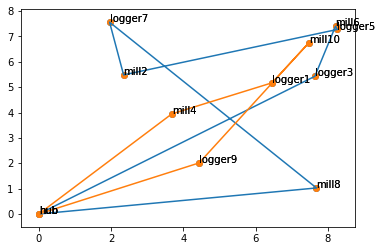


Old 44.16107253460221 -->New 36.288966542694794

Old 33.98995000363063 -->New 20.812862713670643

Final route: [0, 3, 6, 5, 2, 7, 8, 0] 
Total distance: 36.288966542694794

Final route: [0, 9, 10, 1, 4, 0] 
Total distance: 20.812862713670643
Total distance: 57.101829256365434


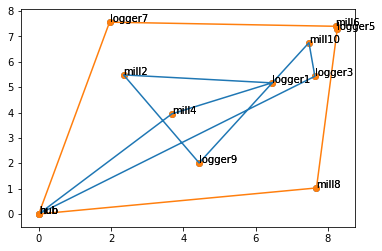


Old 44.16107253460221 -->New 32.92298881050413

Old 33.98995000363063 -->New 28.225787660804365

Final route: [0, 3, 10, 9, 2, 1, 4, 0] 
Total distance: 32.92298881050413

Final route: [0, 7, 6, 5, 8, 0] 
Total distance: 28.225787660804365
Total distance: 61.148776471308494


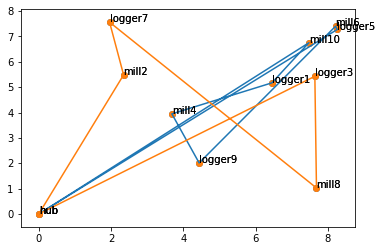


Old 44.16107253460221 -->New 34.777383076887325

Old 33.98995000363063 -->New 30.541839805932803

Final route: [0, 5, 6, 9, 4, 1, 10, 0] 
Total distance: 34.777383076887325

Final route: [0, 3, 8, 7, 2, 0] 
Total distance: 30.541839805932803
Total distance: 65.31922288282013


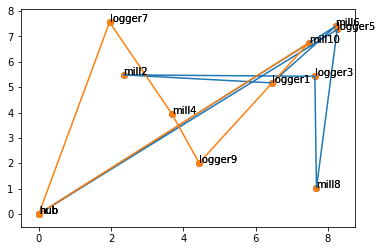


Old 44.16107253460221 -->New 44.97964307819547

Old 33.98995000363063 -->New 29.597344769486746

Final route: [0, 5, 8, 3, 2, 1, 6, 0] 
Total distance: 44.97964307819547

Final route: [0, 7, 4, 9, 10, 0] 
Total distance: 29.597344769486746
Total distance: 74.57698784768222


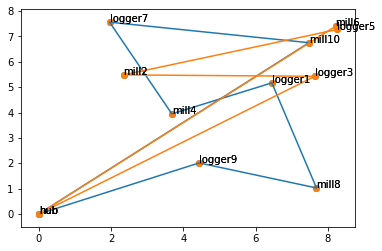


Old 44.16107253460221 -->New 35.26721663633261

Old 33.98995000363063 -->New 32.02526428571562

Final route: [0, 9, 8, 1, 4, 7, 10, 0] 
Total distance: 35.26721663633261

Final route: [0, 3, 2, 5, 6, 0] 
Total distance: 32.02526428571562
Total distance: 67.29248092204824


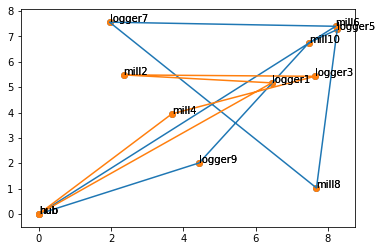


Old 44.16107253460221 -->New 43.710127537167295

Old 33.98995000363063 -->New 27.29301388331991

Final route: [0, 9, 10, 5, 8, 7, 6, 0] 
Total distance: 43.710127537167295

Final route: [0, 1, 2, 3, 4, 0] 
Total distance: 27.29301388331991
Total distance: 71.00314142048721


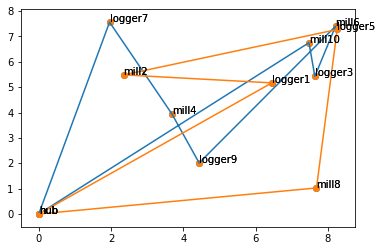


Old 44.16107253460221 -->New 33.9315256493029

Old 33.98995000363063 -->New 32.57876376069066

Final route: [0, 7, 4, 9, 6, 3, 10, 0] 
Total distance: 33.9315256493029

Final route: [0, 1, 2, 5, 8, 0] 
Total distance: 32.57876376069066
Total distance: 66.51028940999356


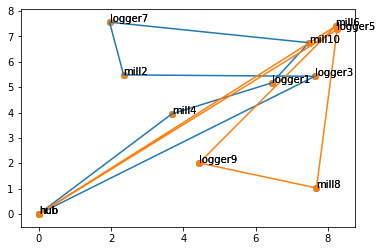


Old 44.16107253460221 -->New 32.663398318728575

Old 33.98995000363063 -->New 38.3000795078489

Final route: [0, 3, 2, 7, 10, 1, 4, 0] 
Total distance: 32.663398318728575

Final route: [0, 5, 8, 9, 6, 0] 
Total distance: 38.3000795078489
Total distance: 70.96347782657747


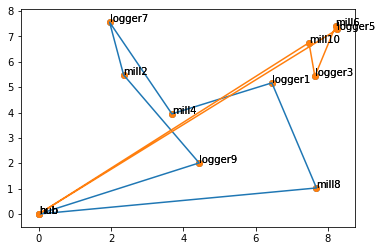


Old 44.16107253460221 -->New 30.142171962652426

Old 33.98995000363063 -->New 24.600746716086768

Final route: [0, 9, 2, 7, 4, 1, 8, 0] 
Total distance: 30.142171962652426

Final route: [0, 5, 6, 3, 10, 0] 
Total distance: 24.600746716086768
Total distance: 54.742918678739194


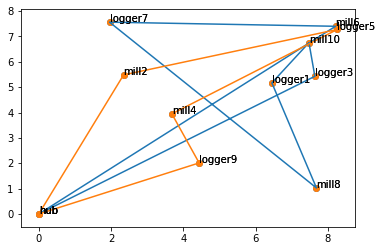


Old 44.16107253460221 -->New 42.91049989412694

Old 33.98995000363063 -->New 24.745184887587165

Final route: [0, 3, 10, 1, 8, 7, 6, 0] 
Total distance: 42.91049989412694

Final route: [0, 9, 4, 5, 2, 0] 
Total distance: 24.745184887587165
Total distance: 67.65568478171411


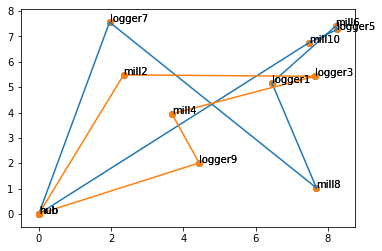


Old 44.16107253460221 -->New 34.813990208089095

Old 33.98995000363063 -->New 22.430118252651603

Final route: [0, 7, 8, 1, 6, 5, 10, 0] 
Total distance: 34.813990208089095

Final route: [0, 9, 4, 3, 2, 0] 
Total distance: 22.430118252651603
Total distance: 57.2441084607407


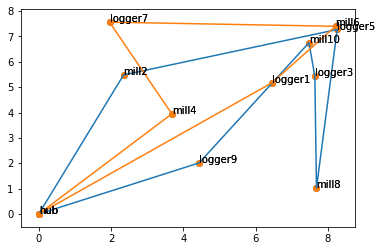


Old 44.16107253460221 -->New 34.652708295235456

Old 33.98995000363063 -->New 26.764290012152653

Final route: [0, 9, 10, 3, 8, 5, 2, 0] 
Total distance: 34.652708295235456

Final route: [0, 1, 6, 7, 4, 0] 
Total distance: 26.764290012152653
Total distance: 61.41699830738811

Final route: [0, 9, 10, 3, 8, 5, 2, 0] 
Total distance: 34.652708295235456

Final route: [0, 1, 6, 7, 4, 0] 
Total distance: 26.764290012152653
Total distance: 61.41699830738811


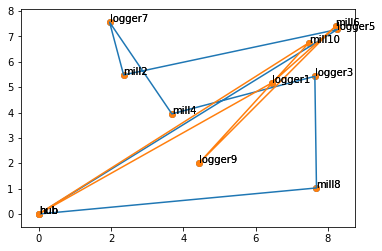


Old 44.16107253460221 -->New 39.676366649690415

Old 33.98995000363063 -->New 33.38776637732124

Final route: [0, 5, 2, 7, 4, 3, 8, 0] 
Total distance: 39.676366649690415

Final route: [0, 1, 6, 9, 10, 0] 
Total distance: 33.38776637732124
Total distance: 73.06413302701165


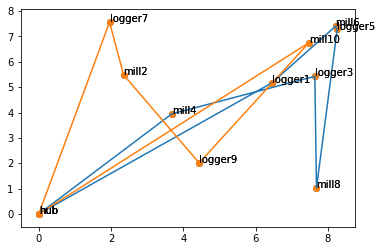


Old 44.16107253460221 -->New 31.54067680602228

Old 33.98995000363063 -->New 29.681988041789843

Final route: [0, 1, 6, 5, 8, 3, 4, 0] 
Total distance: 31.54067680602228

Final route: [0, 7, 2, 9, 10, 0] 
Total distance: 29.681988041789843
Total distance: 61.222664847812126


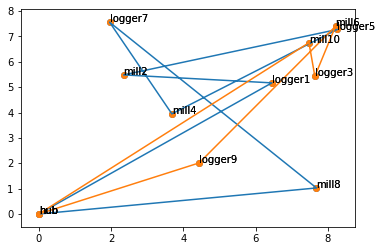


Old 44.16107253460221 -->New 44.65438483394023

Old 33.98995000363063 -->New 24.911033962807778

Final route: [0, 1, 2, 5, 4, 7, 8, 0] 
Total distance: 44.65438483394023

Final route: [0, 9, 6, 3, 10, 0] 
Total distance: 24.911033962807778
Total distance: 69.565418796748


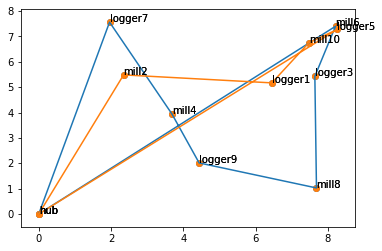


Old 44.16107253460221 -->New 34.79414962105114

Old 33.98995000363063 -->New 23.90954183407345

Final route: [0, 7, 4, 9, 8, 3, 6, 0] 
Total distance: 34.79414962105114

Final route: [0, 5, 10, 1, 2, 0] 
Total distance: 23.90954183407345
Total distance: 58.70369145512459


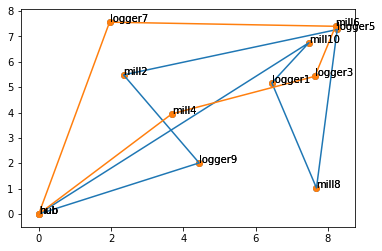


Old 44.16107253460221 -->New 37.65632634513085

Old 33.98995000363063 -->New 25.74130242767796

Final route: [0, 9, 2, 5, 8, 1, 10, 0] 
Total distance: 37.65632634513085

Final route: [0, 7, 6, 3, 4, 0] 
Total distance: 25.74130242767796
Total distance: 63.397628772808815


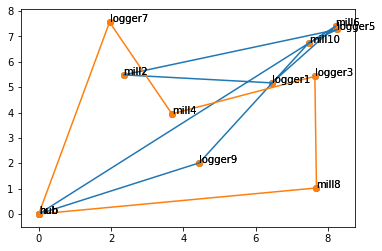


Old 44.16107253460221 -->New 35.62519405609047

Old 33.98995000363063 -->New 28.194987722740088

Final route: [0, 9, 10, 5, 2, 1, 6, 0] 
Total distance: 35.62519405609047

Final route: [0, 7, 4, 3, 8, 0] 
Total distance: 28.194987722740088
Total distance: 63.82018177883056


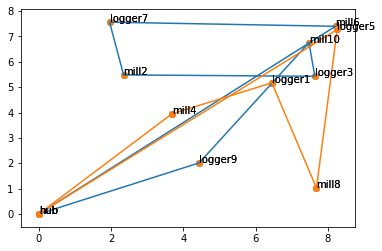


Old 44.16107253460221 -->New 36.54954165853745

Old 33.98995000363063 -->New 30.023358500805717

Final route: [0, 9, 10, 3, 2, 7, 6, 0] 
Total distance: 36.54954165853745

Final route: [0, 5, 8, 1, 4, 0] 
Total distance: 30.023358500805717
Total distance: 66.57290015934316


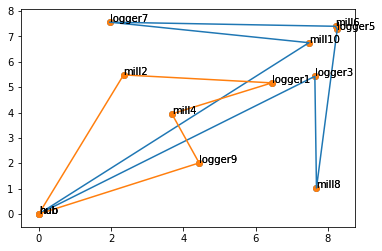


Old 44.16107253460221 -->New 42.0847391214935

Old 33.98995000363063 -->New 20.05204274467016

Final route: [0, 3, 8, 5, 6, 7, 10, 0] 
Total distance: 42.0847391214935

Final route: [0, 9, 4, 1, 2, 0] 
Total distance: 20.05204274467016
Total distance: 62.13678186616366


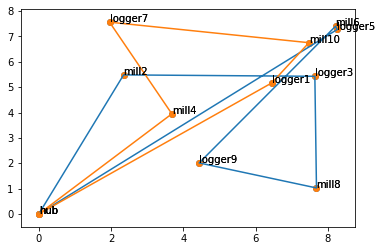


Old 44.16107253460221 -->New 36.76721312570096

Old 33.98995000363063 -->New 25.132028493286132

Final route: [0, 5, 6, 9, 8, 3, 2, 0] 
Total distance: 36.76721312570096

Final route: [0, 1, 10, 7, 4, 0] 
Total distance: 25.132028493286132
Total distance: 61.89924161898709


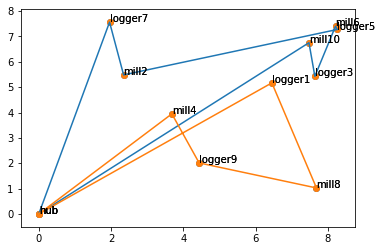


Old 44.16107253460221 -->New 29.698166202312095

Old 33.98995000363063 -->New 23.456180417368508

Final route: [0, 7, 2, 5, 6, 3, 10, 0] 
Total distance: 29.698166202312095

Final route: [0, 1, 8, 9, 4, 0] 
Total distance: 23.456180417368508
Total distance: 53.1543466196806


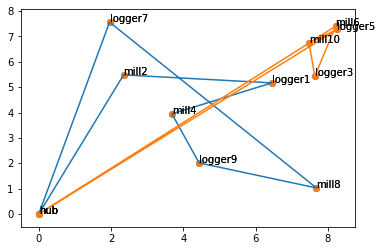


Old 44.16107253460221 -->New 35.07276056104212

Old 33.98995000363063 -->New 26.38397087105877

Final route: [0, 7, 8, 9, 4, 1, 2, 0] 
Total distance: 35.07276056104212

Final route: [0, 5, 10, 3, 6, 0] 
Total distance: 26.38397087105877
Total distance: 61.45673143210089


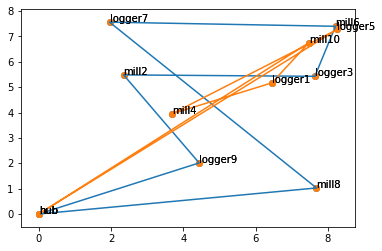


Old 44.16107253460221 -->New 38.96200474626715

Old 33.98995000363063 -->New 31.645427570551703

Final route: [0, 9, 2, 3, 6, 7, 8, 0] 
Total distance: 38.96200474626715

Final route: [0, 5, 4, 1, 10, 0] 
Total distance: 31.645427570551703
Total distance: 70.60743231681886


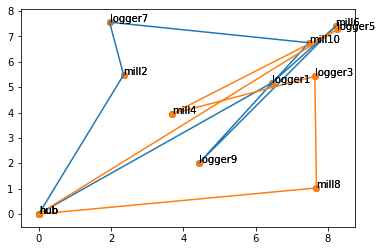


Old 44.16107253460221 -->New 36.9694806476312

Old 33.98995000363063 -->New 33.03800363978144

Final route: [0, 1, 6, 9, 10, 7, 2, 0] 
Total distance: 36.9694806476312

Final route: [0, 5, 4, 3, 8, 0] 
Total distance: 33.03800363978144
Total distance: 70.00748428741264


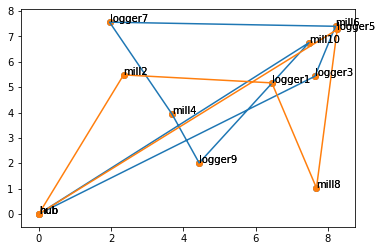


Old 44.16107253460221 -->New 39.46241395319553

Old 33.98995000363063 -->New 31.679195155644678

Final route: [0, 3, 6, 7, 4, 9, 10, 0] 
Total distance: 39.46241395319553

Final route: [0, 5, 8, 1, 2, 0] 
Total distance: 31.679195155644678
Total distance: 71.14160910884021


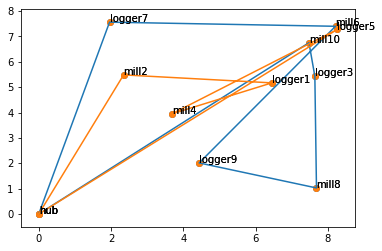


Old 44.16107253460221 -->New 39.84546516646253

Old 33.98995000363063 -->New 29.762758462564335

Final route: [0, 7, 6, 9, 8, 3, 10, 0] 
Total distance: 39.84546516646253

Final route: [0, 5, 4, 1, 2, 0] 
Total distance: 29.762758462564335
Total distance: 69.60822362902687


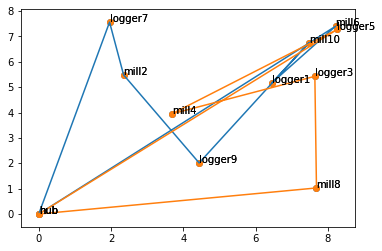


Old 44.16107253460221 -->New 35.39023324944536

Old 33.98995000363063 -->New 33.03800363978144

Final route: [0, 7, 2, 9, 10, 1, 6, 0] 
Total distance: 35.39023324944536

Final route: [0, 5, 4, 3, 8, 0] 
Total distance: 33.03800363978144
Total distance: 68.4282368892268


In [7]:
def main():
    solve(4,init_temp,xcoord,ycoord)
    

# route = [0, 3, 4, 5, 6, 1, 2, 0]
# loggers = generate_loggers(num_loggers)
# mills = generate_mills(num_mills)
# d = availability(route)

# route = generate_rand_path(loggers,mills)
# new_route = generate_path(loggers,mills)
# print(route)
# print(new_route)
main()

In [ ]:
# loggers1 = generate_loggers(3)
# mills1 = generate_mills(3) 
# truck1 = generate_rand_path(loggers1,mills1)

# loggers2 = generate_loggers(2)
# mills2 = generate_mills(2)
# truck2 = generate_rand_path(loggers2,mills2)

# plot_graph(truck1,xcoord,ycoord)
# print(truck1)
# plot_graph(truck2,xcoord,ycoord)
# print(truck2)

# main()

# plot_graph()

# xcoord = []
# # for i in range(10):
# #     n = random.uniform(0,10)
# #     xcoord.append(n)
# # ycoord = []
# # for i in range(0,10):
# #     n = random.uniform(0,10)
# #     ycoord.append(n)
# xcoord = [0,6.449176277857582, 8.210159364492801, 1.9591033904708433,7.683727323272914, 4.437519279118743, 7.475798973242043]
# ycoord = [0,5.169304535502429, 7.400174360896942, 7.562614454164295, 1.0266328053710538, 2.0134066917963, 6.752904060405664]

# dist_mat = np.linspace(0,1,num=16).reshape(4,4)
# for i in range(len(xcoord)//2):
#     for j in range(len(xcoord)//2):
#         dist_mat[i][j] = np.sqrt((ycoord[i]-ycoord[j+4])**2 + (xcoord[i]-xcoord[j+4])**2)
        
# print(dist_mat)
# route = [0, 5, 4, 3, 6, 1, 2, 0] 
# xcoord = [0,6.449176277857582, 8.210159364492801, 1.9591033904708433, 7.683727323272914, 4.437519279118743, 7.475798973242043,0]
# ycoord = [0,5.169304535502429, 7.400174360896942, 7.562614454164295, 1.0266328053710538, 2.0134066917963, 6.752904060405664,0]
# locations = ["hub","logger1","mill2","logger3","mill4","logger5","mill6","hub"]

# plt.scatter(xcoord,ycoord)
# for i, label in enumerate(locations):
#     plt.annotate(label,(xcoord[i],ycoord[i]))
        
# xcoordnew = list()
# ycoordnew = list()
# for i in range(len(route)):
#     xcoordnew.append(xcoord[route[i]])
#     ycoordnew.append(ycoord[route[i]])

# plt.plot(xcoordnew,ycoordnew) 

# plt.show()


            
# plt.scatter(xcoord,ycoord)
# for i, label in enumerate(locations):
#     plt.annotate(label,(xcoord[i],ycoord[i]))
    
# plt.plot(xcoordn2,ycoordn2)
# print(xcoordn2,ycoordn2)
# print(adj_sol)
# print(total_dist(adj_sol,0,1))
# plt.show


# new_sol = [(0,0),(2,2),(1,2)] #244 miles 
# print(demand_mat)
# updated_demand_mat = update_demand(init_sol,0,1)
# print(updated_demand_mat)

# print(find_overserved(init_sol,updated_demand_mat))

# xcoord = [0,6.449176277857582, 8.210159364492801, 1.9591033904708433,7.683727323272914, 4.437519279118743, 7.475798973242043,0]
# ycoord = [0,5.169304535502429, 7.400174360896942, 7.562614454164295, 1.0266328053710538, 2.0134066917963, 6.752904060405664,0]

# loggers = generate_loggers(3)
# mills = generate_mills(3)
# print(loggers,mills)

# path = generate_rand_path(loggers,mills)
# print(path)
# new_path = adjacent(path,rnd)
# print(new_path)

#d = total_dist(new_path,xcoord,ycoord)
# print(d)

# solve(4,init_temp,xcoord,ycoord